In [1]:
import PIL.Image

import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose

import cv2


In [2]:
# Initialize the simulation
adhesion = True
run_time = 1
sim_params = MuJoCoParameters(timestep=2e-4, render_mode="saved", render_playspeed=0.005)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    # Spawn the fly low so that the midleg are touching 
    spawn_pos=(0, 0, 0.3),
)

num_steps_base = int(run_time / nmf.timestep)

In [3]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
# Interpolate 5x
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [5]:
n_stabilization_step = 2000

obs, _ = nmf.reset()
legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
match_joints_to_leg = np.array([[i for i, joint in enumerate(nmf.actuated_joints) if leg in joint] for leg in legs])

leg_stance_starts = {}
leg_swing_starts = {}    

In [6]:
def generate_step(nmf, l):

    nmf.reset()
    i = legs.index(l)
    obs_list = []
    time = []

    for j in range(n_stabilization_step):
        joint_angles = data_block[:, 0]
        action = {"joints": joint_angles, "adhesion":np.zeros(6)}
        obs, _, _, _, _ = nmf.step(action)    
            
    for j in range(interp_step_duration):
        joint_angles = data_block[:, 0]
        joint_angles[match_joints_to_leg[i]] = data_block[match_joints_to_leg[i], j]
        action = {"joints": joint_angles, "adhesion":np.zeros(6)}
        obs, _, _, _, _ = nmf.step(action)
        obs_list.append(obs)
        time.append(nmf.curr_time)
        render_status = nmf.render()
        if render_status:
            cv2.putText(nmf.get_last_frame(), f"{time[-1]:.4f}", (10, 50), 0, 1, (0, 255, 0), 2)
            
    return time, obs_list

# Step right front

In [7]:
l = "RF"
time, obs_list_RF = generate_step(nmf, l)

In [8]:
video_path = Path(f"Single_step/single_step_{l}.mp4")
nmf.save_video(video_path, 0)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

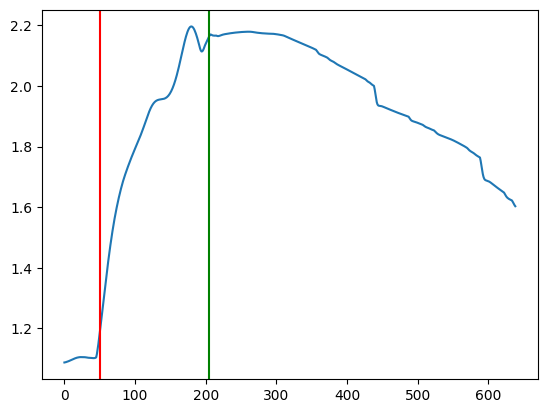

In [9]:
swing_start_t = 0.4104
stance_start_t = 0.4410

time = np.array(time)

leg_stance_starts[l] = np.argmin(np.abs(time - stance_start_t))
leg_swing_starts[l] = np.argmin(np.abs(time - swing_start_t))

k_RF = nmf.last_tarsalseg_names.index(f"{l}Tarsus5")

l_end_effector_zposition = [obs["end_effectors"][k_RF*3] for obs in obs_list_RF]
plt.plot(l_end_effector_zposition)
plt.axvline(leg_swing_starts[l], color="red")
plt.axvline(leg_stance_starts[l], color="green")

# Step Left Front

In [10]:
l = "LF"
time, obs_list_LF = generate_step(nmf, l)

In [11]:
video_path = Path(f"Single_step/single_step_{l}.mp4")
nmf.save_video(video_path, 0)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

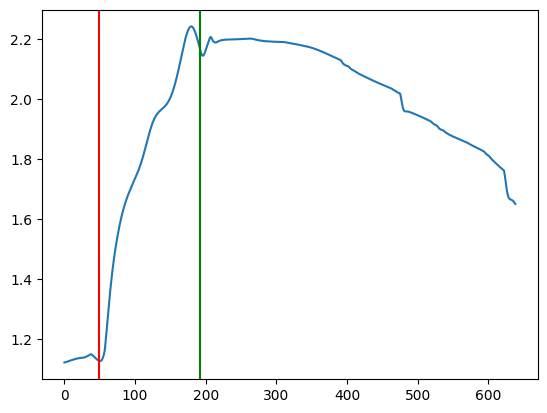

In [12]:
swing_start_t = 0.4100
stance_start_t = 0.4386

time = np.array(time)

leg_stance_starts[l] = np.argmin(np.abs(time - stance_start_t))
leg_swing_starts[l] = np.argmin(np.abs(time - swing_start_t))

k_LF = nmf.last_tarsalseg_names.index(f"{l}Tarsus5")

l_end_effector_zposition = [obs["end_effectors"][k_LF*3] for obs in obs_list_LF]
plt.plot(l_end_effector_zposition)
plt.axvline(leg_swing_starts[l], color="red")
plt.axvline(leg_stance_starts[l], color="green")

# Step Right Middle

In [13]:
l = "RM"
time, obs_list_RM = generate_step(nmf, l)

In [14]:
video_path = Path(f"Single_step/single_step_{l}.mp4")
nmf.save_video(video_path, 0)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

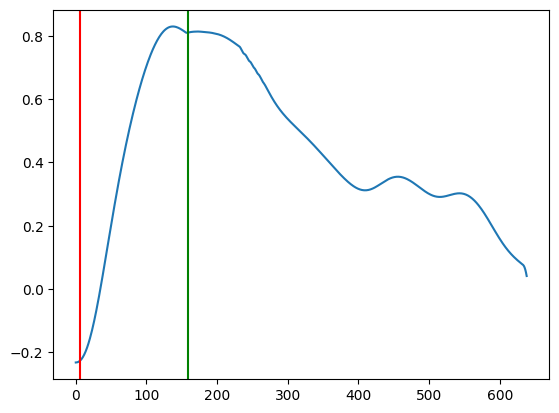

In [15]:
swing_start_t = 0.4014
stance_start_t = 0.4320

time = np.array(time)

leg_stance_starts[l] = np.argmin(np.abs(time - stance_start_t))
leg_swing_starts[l] = np.argmin(np.abs(time - swing_start_t))

k_RM = nmf.last_tarsalseg_names.index(f"{l}Tarsus5")

l_end_effector_zposition = [obs["end_effectors"][k_RM*3] for obs in obs_list_RM]
plt.plot(l_end_effector_zposition)
plt.axvline(leg_swing_starts[l], color="red")
plt.axvline(leg_stance_starts[l], color="green")

# Step left middle

In [16]:
l = "LM"
time, obs_list_LM = generate_step(nmf, l)

In [17]:
video_path = Path(f"Single_step/single_step_{l}.mp4")
nmf.save_video(video_path, 0)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

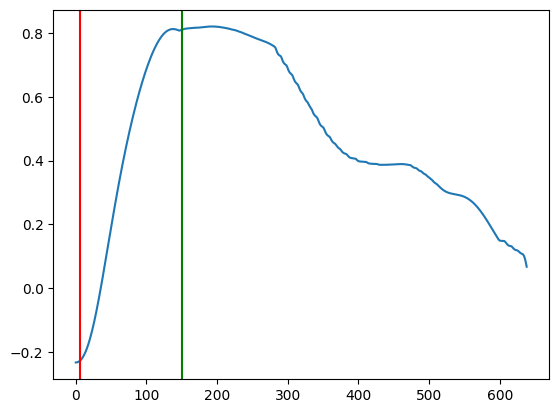

In [18]:
swing_start_t = 0.4014
stance_start_t = 0.4302

time = np.array(time)

leg_stance_starts[l] = np.argmin(np.abs(time - stance_start_t))
leg_swing_starts[l] = np.argmin(np.abs(time - swing_start_t))

k_LM = nmf.last_tarsalseg_names.index(f"{l}Tarsus5")

l_end_effector_zposition = [obs["end_effectors"][k_LM*3] for obs in obs_list_LM]
plt.plot(l_end_effector_zposition)
plt.axvline(leg_swing_starts[l], color="red")
plt.axvline(leg_stance_starts[l], color="green")

# Step right hind

In [19]:
l = "RH"
time, obs_list_RH = generate_step(nmf, l)

In [20]:
video_path = Path(f"Single_step/single_step_{l}.mp4")
nmf.save_video(video_path, 0)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

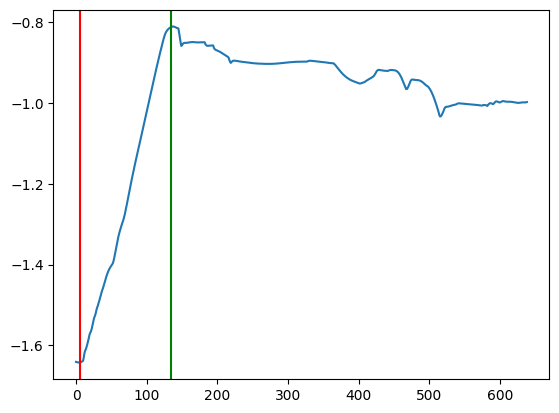

In [21]:
swing_start_t = 0.4014
stance_start_t = 0.4270

time = np.array(time)

leg_stance_starts[l] = np.argmin(np.abs(time - stance_start_t))
leg_swing_starts[l] = np.argmin(np.abs(time - swing_start_t))

k_RH = nmf.last_tarsalseg_names.index(f"{l}Tarsus5")

l_end_effector_zposition = [obs["end_effectors"][k_RH*3] for obs in obs_list_RH]
plt.plot(l_end_effector_zposition)
plt.axvline(leg_swing_starts[l], color="red")
plt.axvline(leg_stance_starts[l], color="green")

# Step Left Hind

In [22]:
l = "LH"
time, obs_list_LH = generate_step(nmf, l)

In [23]:
video_path = Path(f"Single_step/single_step_{l}.mp4")
nmf.save_video(video_path, 0)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

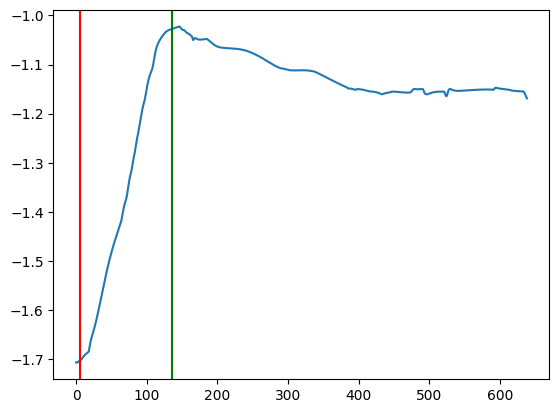

In [24]:
swing_start_t = 0.4014
stance_start_t = 0.4274

time = np.array(time)

leg_stance_starts[l] = np.argmin(np.abs(time - stance_start_t))
leg_swing_starts[l] = np.argmin(np.abs(time - swing_start_t))

k_LH = nmf.last_tarsalseg_names.index(f"{l}Tarsus5")

l_end_effector_zposition = [obs["end_effectors"][k_LH*3] for obs in obs_list_LH]
plt.plot(l_end_effector_zposition)
plt.axvline(leg_swing_starts[l], color="red")
plt.axvline(leg_stance_starts[l], color="green")

# Analyze stance and swing starts

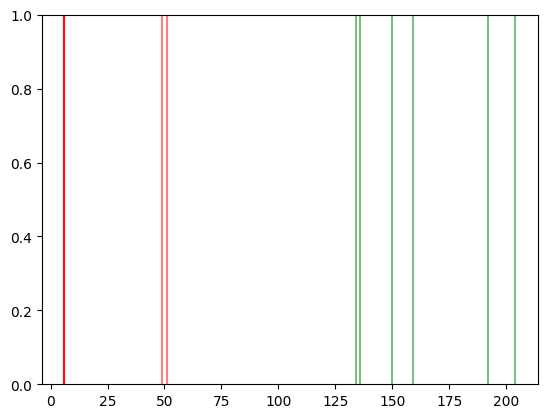

In [25]:
for leg in legs:
    plt.axvline(leg_swing_starts[leg], color='r', alpha = 0.5)
    plt.axvline(leg_stance_starts[leg], color='g', alpha = 0.5)

In [26]:
# The distribution seems pretty wide lets take the min for the swing stance and the maximum for the stance start making the stance as long as possible

swing_starts = [s for l, s in leg_swing_starts.items()]
stance_starts = [s for l, s in leg_stance_starts.items()]

print(f"swing start idx: {swing_starts}")
print(f"stance start idx: {stance_starts}")

swing start idx: [51, 49, 6, 6, 6, 6]
stance start idx: [204, 192, 159, 150, 134, 136]


In [27]:
#assert not "swing_stance_idx" in data, "swing_stance_idx already exists in data change this line if you want to overwrite it"
data["swing_stance_idx"] = {"min_swing_start_idx":min(swing_starts), "min_stance_start_idx":min(stance_starts),
                            "max_swing_start_idx":max(swing_starts), "max_stance_start_idx":max(stance_starts)}

# save to pickle
with open(data_path / 'behavior' / 'single_steps.pkl', "wb") as f:
    pickle.dump(data, f)

In [28]:
 # Load and check data
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)
data["swing_stance_idx"]

{'min_swing_start_idx': 6,
 'min_stance_start_idx': 134,
 'max_swing_start_idx': 51,
 'max_stance_start_idx': 204}